In [1]:
import numpy as np
import json
from ast import literal_eval
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
poles = pd.read_csv('../data/bird_poles.csv')

In [3]:
poles.head()

,Identifier,Plate Name,Area,Latitude,Longitude,Rotation_Rate,Reference
0,AF,Africa,1.44065,59.160,−73.174,0.9270,DeMets et al. [1994]
1,AM,Amur,0.13066,57.645,−83.736,0.9309,Heki et al. [1999]
2,AN,Antarctica,1.43268,64.315,−83.984,0.8695,DeMets et al. [1994]
3,AP,Altiplano,0.02050,33.639,−81.177,0.9160,Lamb [2000]
4,AR,Arabia,0.12082,59.658,−33.193,1.1616,DeMets et al. [1994]


In [4]:
with open('../data/eur_nam.geojson') as ff:
    eur_nam_gj = json.load(ff)

In [5]:
eur_nam_gj

{'crs': {'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'},
  'type': 'name'},
 'features': [{'geometry': {'coordinates': [[-29.278, 40.871],
     [-29.27631, 40.879769],
     [-29.27462, 40.888539],
     [-29.27293, 40.897308],
     [-29.271239, 40.906078],
     [-29.269547, 40.914847],
     [-29.267856, 40.923616],
     [-29.266163, 40.932385],
     [-29.26447, 40.941155],
     [-29.262777, 40.949924],
     [-29.261084, 40.958693],
     [-29.25939, 40.967462],
     [-29.257695, 40.976231],
     [-29.256, 40.985]],
    'type': 'LineString'},
   'properties': {'accuracy': None,
    'activity_confidence': '1',
    'average_dip': None,
    'average_rake': None,
    'catalog_id': 'PB_2359.0',
    'catalog_name': 'Bird 2003',
    'dip_dir': None,
    'downthrown_side_dir': None,
    'downthrown_side_id': None,
    'epistemic_quality': '1',
    'exposure_quality': None,
    'fz_name': None,
    'last_movement': None,
    'lower_seis_depth': None,
    'name': None,
    'net_slip_rate':

1. calculate the slip vector for each fault
    (vector is top relative to bottom)
    1. calculate fault strike
    2. calculate horizontal slip vector
        1. calculate ve, vn from spreading/shortening
        2. calculate ve, vn from strike-slip
        3. add them.

In [6]:
def extract_number(tup_str):
    return literal_eval(tup_str.strip('(').split(',')[0])

In [7]:
extract_number(eur_nam_gj['features'][0]['properties']['shortening_rate'])

-23.0

In [8]:
f0 = eur_nam_gj['features'][0]

In [28]:
def calc_strike(lon0, lat0, lon1, lat1):
    
    y = np.sin(lon1-lon0) * np.cos(lat1)
    x = np.cos(lat0) * np.sin(lat1) \
        - np.sin(lat0) * np.cos(lat1) * np.cos(lon1-lon0)
    
    return angle_to_az(np.arctan2(y,x))
    

def az_to_angle(az):
    #az_r = np.radians(az)
    #return np.pi/2 - az_r
    
    return np.radians(90-az)

def angle_to_az(angle):
    return -(np.degrees(angle) - 90)


def rotate_vecs(dx, dy, strike):
    ang = az_to_angle(strike)
    
    de = dx * np.cos(ang) - dy * np.sin(ang)
    dn = dx * np.sin(ang) + dy * np.cos(ang)
    
    return np.array([de, dn])

def fault_strike(fault):
    lon0, lat0 = np.radians(fault['geometry']['coordinates'][0])
    lon1, lat1 = np.radians(fault['geometry']['coordinates'][-1])
    
    return calc_strike(lon0, lat0, lon1, lat1)

In [44]:
def slip_vec_to_ven(dex, ext, strike):
    return rotate_vecs(dex, ext, strike)

In [30]:
angle_to_az(az_to_angle(-36))

-36.0

In [59]:
def test_slip_vec_to_ven():
    
    sqrt2 = np.sqrt(2.)
    
    def test_args(args, outs):
        if np.allclose(slip_vec_to_ven(*args),
                              np.array(outs)):
            print('passes on', args)
    
        else:
            print('fails on', args)
            
    test_dict = {
        (1.,0.,0.): (0.,1.),
        (1.,0.,45.): (sqrt2/2.,sqrt2/2.),
        (1.,0.,90.): (1.,0.),
        (1.,0.,135.): (sqrt2/2.,-sqrt2/2.),
        
        (0.,1.,0.): (-1.,0.),
        (0.,1.,45.): (-sqrt2/2., sqrt2/2),
        (0.,1.,90.): (0.,1.),
        (0.,1.,135): (sqrt2/2., sqrt2/2.),
        
        (1.,1.,0.): (-1.,1),
        (-1., 1.,0.): (-1,-1),
        (1.,-1.,0.): (1,1),
        (-1,-1,0.): (1,-1),
        
        (1.,1.,45.): (0.,sqrt2),
        (-1.,1.,45.): (-sqrt2,0.),
        (1.,-1.,45.): (sqrt2,0.),
        (-1.,-1.,45.): (0.,-sqrt2),
        (1.,1.,90.): (1.,1.),
        (-1.,1.,90.): (-1.,1.),
        (1.,-1.,90.): (1.,-1.),
        (-1.,-1.,90.): (-1.,-1.),
        (1.,1.,135.): (sqrt2,0.),
        (-1.,1.,135.): (0.,sqrt2),
        (1.,-1.,135.): (0.,-sqrt2),
        (-1.,-1.,135.): (-sqrt2,0.),
                 
                
                
                
                
                }
    
    for args, outs in test_dict.items():
        test_args(args, outs)
            
    
                

In [60]:
slip_vec_to_ven(1,-1,0.)

array([1., 1.])

In [61]:
test_slip_vec_to_ven()

passes on (1.0, 0.0, 0.0)
passes on (1.0, 0.0, 45.0)
passes on (1.0, 0.0, 90.0)
passes on (1.0, 0.0, 135.0)
passes on (0.0, 1.0, 0.0)
passes on (0.0, 1.0, 45.0)
passes on (0.0, 1.0, 90.0)
passes on (0.0, 1.0, 135)
passes on (1.0, 1.0, 0.0)
passes on (-1.0, 1.0, 0.0)
passes on (1.0, -1.0, 0.0)
passes on (-1, -1, 0.0)
passes on (1.0, 1.0, 45.0)
passes on (-1.0, 1.0, 45.0)
passes on (1.0, -1.0, 45.0)
passes on (-1.0, -1.0, 45.0)
passes on (1.0, 1.0, 90.0)
passes on (-1.0, 1.0, 90.0)
passes on (1.0, -1.0, 90.0)
passes on (-1.0, -1.0, 90.0)
passes on (1.0, 1.0, 135.0)
passes on (-1.0, 1.0, 135.0)
passes on (1.0, -1.0, 135.0)
passes on (-1.0, -1.0, 135.0)


In [146]:
az_to_angle(-90)

3.141592653589793

In [126]:
for ang in (0, 45, 90, 135, 180, 225, 270, 315):
    print(ang, np.degrees(az_to_angle(ang)))

0 90.0
45 45.0
90 0.0
135 -45.0
180 -90.0
225 -135.0
270 -180.0
315 -225.0


In [124]:
slip_vec_to_ven(1, 0, 90)

array([-1.0000000e+00,  1.2246468e-16])

In [118]:
slip_vec_to_ven(1,1,0)

array([-1.,  1.])

In [13]:
slip_vec_to_ven(1,-1,0)

(1.0, 0.9999999999999999)

In [14]:
slip_vec_to_ven(1,1, 90)

(-1.0000000000000002, -0.9999999999999999)

In [15]:
rotate_vecs(1,0,0)

(6.123233995736766e-17, 1.0)

In [16]:
np.degrees(fault_strike(f0))

8.28833343301121

In [145]:
calc_strike(0,0,1,0)

-0.0

(-29.2791, -29.2549, 40.865300000000005, 40.9907)

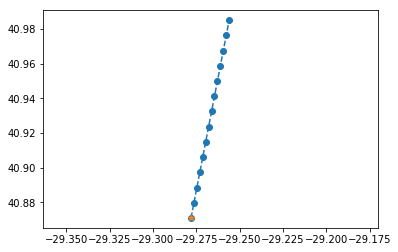

In [18]:
plt.plot(np.array(f0['geometry']['coordinates'])[:,0],
         np.array(f0['geometry']['coordinates'])[:,1],
         'o--')

plt.plot(np.array(f0['geometry']['coordinates'])[0,0],
         np.array(f0['geometry']['coordinates'])[0,1],
         '*')

plt.axis('equal')

In [19]:
def get_slip_vector(fault):
    ext_rate = -1 * extract_number(fault['properties']['shortening_rate'])
    ss_rate = extract_number(fault['properties']['strike_slip_rate'])
    
    